In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

c:\ProgramData\anaconda3\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model = models.resnet18(weights=None) # not pretrained
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) # Change input channels from 3 to 1 (grayscale images)
model.fc = nn.Linear(512, 14)  # final fully connected layer

model.load_state_dict(torch.load('pre-trained_resnet18.pt'))

model = model.to(device) # move the model to the GPU

C:\Users\mamou\AppData\Local\Temp\ipykernel_17500\3784850978.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('pre-trained_resnet18.pt'))

In [4]:
from torchvision import transforms
from PIL import Image

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load and process single image
img = Image.open('test_images/image_3.png')
img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

# Inference
model.eval()
with torch.no_grad():
    output = model(img_tensor)

In [6]:
class_names = [
    'Atelectasis',
    'Cardiomegaly',
    'Effusion',
    'Infiltration',
    'Mass',
    'Nodule',
    'Pneumonia',
    'Pneumothorax',
    'Consolidation',
    'Edema',
    'Emphysema',
    'Fibrosis',
    'Pleural_Thickening',
    'Hernia'
]

probabilities = torch.sigmoid(output).squeeze().cpu().numpy()
for i, prob in enumerate(probabilities):
    print(f"Label {i}: {prob:.3f}")


Label 0: 0.129
Label 1: 0.088
Label 2: 0.174
Label 3: 0.161
Label 4: 0.043
Label 5: 0.061
Label 6: 0.029
Label 7: 0.015
Label 8: 0.030
Label 9: 0.025
Label 10: 0.035
Label 11: 0.011
Label 12: 0.046
Label 13: 0.002


In [7]:
data = np.load('chestmnist_224.npz')

test_images = data['test_images']
test_labels = data['test_labels']


In [8]:
class ChestMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self): 
        return len(self.images) # number of samples
    
    def __getitem__(self, idx):
        img = self.images[idx]

        if self.transform: # apply transformations
            img = self.transform(img)

        label = self.labels[idx]
        label = torch.tensor(label, dtype=torch.float)
        
        return img, label

In [9]:
transforms = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Normalize((0.5,), (0.5,)) # normalize the images
])

In [10]:
test_dataset = ChestMNISTDataset(test_images, test_labels, transform=transforms)

In [11]:
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [12]:
# calculate test accuracy

model.eval() # set the model to evaluation mode
with torch.no_grad():
    all_predictions = []
    all_labels = []
    
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions = torch.sigmoid(outputs) > 0.5
        
        all_predictions.append(predictions.cpu())
        all_labels.append(targets.cpu())
    
    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)
    
    test_accuracy = (all_predictions == all_labels).float().mean().item()
    print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9478


In [13]:
print(f"Positive labels per class: {all_labels.sum(dim=0)}")
print(f"Total samples: {len(all_labels)}")

Positive labels per class: tensor([2420.,  582., 2754., 3938., 1133., 1335.,  242., 1089.,  957.,  413.,
         509.,  362.,  734.,   42.])
Total samples: 22433


c:\ProgramData\anaconda3\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Available arrays: ['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']


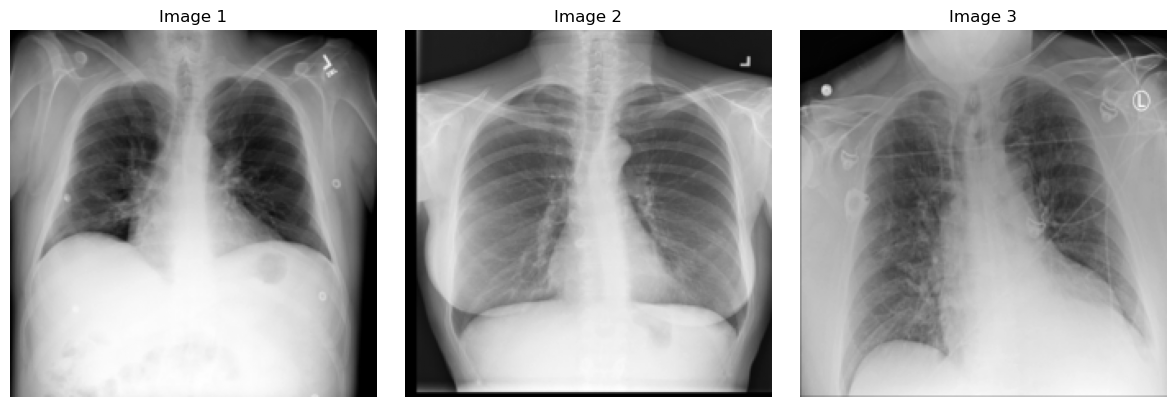

Selected images shape: (3, 224, 224)
PyTorch tensor shape: torch.Size([3, 224, 224])
Images saved!


In [ ]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt

# import os
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# # Load the .npz file
# data = np.load('chestmnist_224.npz')

# # Get all available arrays (train/test images)
# print("Available arrays:", data.files)

# # Combine train and test images
# test_images = data['test_images']    # Adjust key name as needed

# # Randomly select 3 images
# random_indices = np.random.choice(len(test_images), size=3, replace=False)
# selected_images = test_images[random_indices]

# # Convert to PyTorch tensor if needed
# images_tensor = torch.from_numpy(selected_images)

# # Display the images
# fig, axes = plt.subplots(1, 3, figsize=(12, 4))
# for i, img in enumerate(selected_images):
#     axes[i].imshow(img.squeeze(), cmap='gray')  # Remove .squeeze() if RGB
#     axes[i].axis('off')
#     axes[i].set_title(f'Image {i+1}')
# plt.tight_layout()
# plt.show()

# print(f"Selected images shape: {selected_images.shape}")
# print(f"PyTorch tensor shape: {images_tensor.shape}")

# # Save the 3 images
# np.savez('selected_images.npz', images=selected_images, indices=random_indices)

# # Or save as individual image files
# from PIL import Image
# for i, img in enumerate(selected_images):
#     # Normalize to 0-255 range if needed
#     img_normalized = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
#     Image.fromarray(img_normalized.squeeze()).save(f'image_{i+1}.png')

# print("Images saved!")